# Cotrending basis vector correction for TESS light curves

This Jupyter notebook shows how to create the Sector 34 light curve of TOI-560 as it appears in [Barragán et al., 2022, MNRAS, 514, 1606](https://academic.oup.com/mnras/advance-article/doi/10.1093/mnras/stac638/6548902)

If you use this jupyter notebook for your research, please cite [Lightkurve collaboration et al., 2018](https://ui.adsabs.harvard.edu/abs/2018ascl.soft12013L/abstract) and [Barragán et al., 2022, MNRAS, 514, 1606](https://academic.oup.com/mnras/advance-article/doi/10.1093/mnras/stac638/6548902).

This jupyter notebook is a wrap of the info given in the following links
https://heasarc.gsfc.nasa.gov/docs/tess/UnderstandingCrowding.html
https://docs.lightkurve.org/tutorials/2-creating-light-curves/2-3-how-to-use-cbvcorrector.html

In [7]:
%matplotlib inline

In [3]:
#Let's import the libraries, we use all the magic given in lightkurve package
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt
from lightkurve.correctors import RegressionCorrector, DesignMatrix
from lightkurve.correctors import PLDCorrector
import warnings

## What is wrong with the PDCSAP data of TOI-560?

Let's first check what data are available to download for TOI-560 (we need the TIC ID of the target, in this case is TIC 101011575)

In [4]:
# search_lk = lk.search_lightcurve("TIC 101011575")
search_lk = lk.search_lightcurve("TIC 460950389")
search_lk

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 64,2023,SPOC,120,460950389,0.0
1,TESS Sector 63,2023,SPOC,120,460950389,0.0
2,TESS Sector 90,2025,SPOC,20,460950389,0.0
3,TESS Sector 90,2025,SPOC,120,460950389,0.0
4,TESS Sector 10,2019,TESS-SPOC,1800,460950389,0.0
5,TESS Sector 37,2021,TESS-SPOC,600,460950389,0.0
6,TESS Sector 64,2023,TESS-SPOC,200,460950389,0.0
7,TESS Sector 63,2023,TESS-SPOC,200,460950389,0.0
8,TESS Sector 10,2019,QLP,1800,460950389,0.0


<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

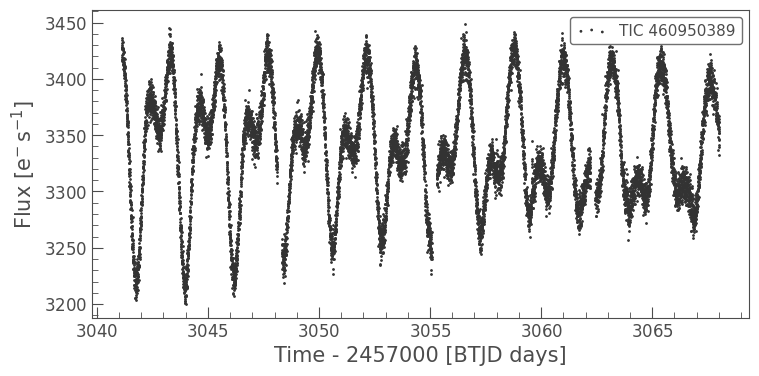

In [16]:
lc = search_lk[6].download()
lc.scatter()

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='sap_flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

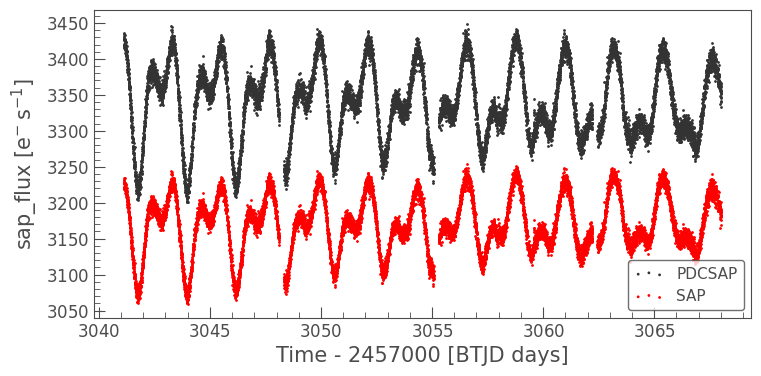

In [17]:
ax = lc.scatter(normalize=False, column='pdcsap_flux', label='PDCSAP')
lc.scatter(ax=ax, column='sap_flux', normalize=False, color='red', label='SAP')

We now can see that the SAP light curve does not contain "strange" signals in the second half of the data. This makes us suspicious. So if we go to the TESS' [Sector 34 release notes](https://tasoc.dk/docs/release_notes/tess_sector_34_drn50_v02.pdf), we can see that orbit 76 (i.e., the second half of Sector 34) suffered from significant spacecraft motion. This suggests that the apparent PDCSAP light curve corruption is likely caused by an over-fitting of the Cotrending Base Vectors (CBVs) when trying to correct the significant spacecraft motion. 

## Our own CBVs correction

In the previous cells, we  worked with the light curve data products, if we want to do our own CBVs correction, we need to go one step back to work at the pixel level with Target Pixel Files (TPFs). Fortunatelly, lightkurve magic also allow us to work with TPFs in an easy way. So let's download the Sector 34 TPF for TOI-560 (TIC 101011575).

In [ ]:
#Let us download the data and save it in a tpf object called tpf
tpf = lk.search_targetpixelfile('TIC 101011575', sector=34).download(quality_bitmask='hardest')

In [ ]:
#Let us plot the CCD and the SAP just for fun 
tpf.plot(aperture_mask=tpf.pipeline_mask)

### Creating a light curve from a TPF

So now we have our TPF object, and we are happy with the default aperture. Now we can create a light curve object from the TPF (This will create a light curve equivalent to the SAP light curve). 

In [ ]:
#Create the light curve with the lightkurve magic
tpf_lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask)
#Plot the light curve just to be sure we have the correct data
tpf_lc.scatter()

We can see that we have the SEctor 34 light curve of TOI-560, similar to the SAP light curve that we plotted before. So now we have the light curve that we want to correct, time to extract the CBVs.

### Correct the light curve with CBVs

As we can suspect, lightkurve has all the modules requiered to do the CBVs correction, we just need to know how to do it, in what order, and how to know if we are doing it correctly. So let's import the requiered libraries and extract the CBVs corresponding to our problem.

In [ ]:
#Import CBVCorrector 
from lightkurve.correctors import CBVCorrector
#Extract the CBVs that correspond to the TPF that we downloaded before, CBVs depend on Sector, Camera, CCD, etc.
cbvCorrector = CBVCorrector(tpf_lc)
#Let us see what CBVs information we have now
cbvCorrector.cbvs

We can see that there are five different types of CBVs, one SingleSccale, three MultiScale and one Spike. More details about this can be found [here](https://docs.lightkurve.org/tutorials/2-creating-light-curves/2-3-how-to-use-cbvcorrector.html#Obtaining-the-CBVs).

Let's see how the SingleScale CBVs look

In [ ]:
#Let us plot the 0 entry of the cbvCorrector.cbvs object that contains the SingleScale CBVs
cbvCorrector.cbvs[0].plot()

We can see that these CBVs contain information about the behaviour of the systematics at all times in the light curve. We can also see that the first last 8 components do not have any information for this sector. Quoting the [documentation](https://docs.lightkurve.org/tutorials/2-creating-light-curves/2-3-how-to-use-cbvcorrector.html#Obtaining-the-CBVs) "The first several CBVs contain most of the systematics. The latter CBVs pose a greater risk of injecting more noise than helping. The default behavior in CBVCorrector is to use the first 8 CBVs". So we are good.

Now let's give a look to the Spike CBVs

In [ ]:
#Let us plot the 4 entry of the cbvCorrector.cbvs object that contains the SingleScale CBVs
cbvCorrector.cbvs[4].plot()

We can see that these CBVs contain information about the behaviour of the systematics at specific times of the light curve (maybe you already noticed that the Spike CBVs are significant in the ugly areas of the PDCSAP light curve of this target).

So now we have the CBVs, time to do the correction. Let's do the correction that is suggested in the documentation.

In [ ]:
#################################################
#This is a copy and paste from the documentation#
#################################################
# Select which CBVs to use in the correction
cbv_type = ['SingleScale', 'Spike']
# Select which CBV indices to use
# Use the first 8 SingleScale and all Spike CBVS
cbv_indices = [np.arange(1,9), 'ALL']
# Perform the correction
cbvCorrector.correct_gaussian_prior(cbv_type=cbv_type, cbv_indices=cbv_indices, alpha=1e-4)
cbvCorrector.diagnose();

In the top panel we can see the SAP lc (gray), the CBV Single Scale correction (blue), the Spike correction (Green) and an offset (orange). All of this info is combined to create the corrected lc (black) in the bottom panel. We can see by eye that this corrected lc looks systematic dominated, just as the PDC SAP lc! Of course, saying that the light curve looks ugly is not scientific enough to discard a data set, so we need to be more quantitative. The secret is in the "alpha" parameter in the line

cbvCorrector.correct_gaussian_prior(cbv_type=cbv_type, cbv_indices=cbv_indices, **alpha=1e-4**)

a small value of alpha means a strong CBV correction, while a small value of alpha means a weak CBV correction. Of course a strong correction can create an overfitting and a weak correction an underfitting. It is possible to obtain the Underfit and Overfit metrics to check the quality of the CBVs correction. Following the documentation, we should aim for a value larger than 0.8 for both values. Let's check the goodness metrics for our current alpha value.  

In [ ]:
#Check goodness of metric with the current alpha value
with warnings.catch_warnings():
    # ignore "RuntimeWarning"
    warnings.simplefilter("ignore", RuntimeWarning)
    cbvCorrector.goodness_metric_scan_plot(cbv_type=cbv_type, cbv_indices=cbv_indices)

We can see that with an alpha of 1e-4 the Overfit metric has a value of ~0.5 that is smaller than the recomended threshold of 0.8. We therefore can conclude that our CBVs correction is overfitted and this generates systematics signals in the light curve. But not everything is lost, we can find what is the optimal alpha value that gives the best CBV correction. 

In [ ]:
#Lets make a diagnostic of alpha values to check what is the optimal alpha value
#Let's ask to the code to search a score of 0.8 or more for the over and under fit metric
cbvCorrector.correct(cbv_type=cbv_type,
                     cbv_indices=cbv_indices,
                     target_over_score=0.8,
                     target_under_score=0.8)
cbvCorrector.goodness_metric_scan_plot(cbv_type=cbv_type, cbv_indices=cbv_indices);

We can see that the suggested value of alpha is now ~1e4. This is a conservative value that implies that the light curve correction is minimal. Let us check how the light curve looks now.

In [ ]:
cbvCorrector.diagnose();

We can see that a value of alpha ~1e4 the corrected light curve is practically identical to the SAP light curve. This suggest that (depending on our scientific goals) we can use the SAP light curve shape (not as it is, you also need to correct for **crowding**! More of it below).
So we could just correct for crowding and we would have a light curve ready to do science. 
But we can go a bit further, as we saw before, this particular sector suffered from spacecraft motion, so maybe we can correct only for this ;-) 

### SPIKE only CBV correction

Let's try to correct only for the Spike CBVs that include information about abrupt changes in TESS. It is practically the same as before, but in cbv_type we only include 'Spike'

In [ ]:
# Select which CBVs to use in the correction
cbv_type = ['Spike']
cbv_indices = [ 'ALL']
# Perform the correction
#Let's use a alpha of 1e-4 to enforce a strong correction
cbvCorrector.correct_gaussian_prior(cbv_type=cbv_type, cbv_indices=cbv_indices, alpha=1e-4)
cbvCorrector.diagnose()

In the top panel we can see the SAP lc (gray), the Spike correction (Blue) and an offset (green). All of this info is combined to create the corrected lc (black) in the bottom panel. We can see that the Spike correction is acting only in the ugly parts of the lc, but it preserves the shape of the SAP light curve. Let us check if this alpha value gives good values for the goodness metrics.

In [ ]:
with warnings.catch_warnings():
    # ignore "RuntimeWarning"
    warnings.simplefilter("ignore", RuntimeWarning)
    cbvCorrector.goodness_metric_scan_plot(cbv_type=cbv_type, cbv_indices=cbv_indices)

We can see that both of our goodness metrics give values well above 0.8. So we are certain that an alpha value of 1e-4 does not over or under fit the data. The plot shows that practically any value of alpha will give values above 0.8, so in this case it is not clear how to chose the optimal model (I am not the one saying this, the [documentation](https://docs.lightkurve.org/tutorials/2-creating-light-curves/2-3-how-to-use-cbvcorrector.html#No-Single-Best-Answer-Example) says it). My approach here is, I want to correct by spacecraft motion, and if a strong correction does not seem to overfit the model, then I go with it. 

## Correcting for Crowding

##### Following the tutorial given [here](https://heasarc.gsfc.nasa.gov/docs/tess/UnderstandingCrowding.html). 

The final step to have a lc ready to do the science is to correct for crowding. Fortunatelly, the numbers that we need to correct for crowding are inside the header of the TPF we downloaded previously. We need to extract the CROWDSAP and FLFRCSAP that contain the crowding metrics.

In [ ]:
CROWDSAP = tpf.hdu[1].header['CROWDSAP']
CROWDSAP

In [ ]:
FLFRCSAP = tpf.hdu[1].header['FLFRCSAP']
FLFRCSAP

From the above values, we see that the aperture contains only 93% of the object’s flux, and an extra 4% of the flux in the aperture is due to other objects.

###### The description and code below comes exactly from the tutorial given [here](https://heasarc.gsfc.nasa.gov/docs/tess/UnderstandingCrowding.html).

In [ ]:
#To correct for the crowding and missing flux, we must first calculate the median flux of our time series. 
#Note that we want only data that is of a high quality, which is why we originally set our quality_mask as hard.
median_flux = np.median(cbvCorrector.corrected_lc.flux.value)
#The excess flux in the aperture is then calculated as (1-CROWDSAP) times the median flux
excess_flux = (1-CROWDSAP)*median_flux
#This excess flux must then be subtracted from the time series data
flux_removed = cbvCorrector.corrected_lc.flux.value  - excess_flux
#This residual flux, however, does not account for the flux of our object outside of the aperture, 
#as such there is one more correction to apply - FLFRCSA.
flux_corr = flux_removed/FLFRCSAP
#The uncertainties on this flux are also now altered to be
flux_err_corr = cbvCorrector.corrected_lc.flux_err.value/FLFRCSAP
#We can now convert this into a LightCurve Object again via the following
lc_cbv_corr = lk.LightCurve(time=tpf.time.value, flux=flux_corr, flux_err=flux_err_corr)

#### And now we have our corrected light curve stored in **lc_cbv_corr**, let's plot it!

In [ ]:
ax = tpf_lc.scatter(normalize=True, color='red', label='SAP ORIGINAL',alpha=0.5)
#lc.scatter(ax=ax, normalize=True, label='PDCSAP',alpha=0.5)
lc_cbv_corr.scatter(ax=ax, normalize=True, color='cyan', label='CBV Corrected', alpha=0.5)

We can see the SAP and our CBV corrected light curve. We can see how the SAP and CBV corrected light curve look similar, but our corrected light curve has less scatter than the SAP at the times in which the telescope had significant spacecraft motion. 

### Save the data

Now we only need to save the data in our favourite format. 

In [ ]:
#Let's not forget to normalise the flux and the errors because everything is given in counts 
e = lc_cbv_corr.flux_err/np.mean(lc_cbv_corr.flux)
f = lc_cbv_corr.flux/np.mean(lc_cbv_corr.flux)

In [ ]:
#save the data in an ascii file
fname = 'toi560_sec34_cbvcorrected.dat'
with open(fname,'w') as datos:
    for i in range(len(lc_cbv_corr.time)):
        datos.write('{}  {} {} \n'.format(lc_cbv_corr.time[i],f[i],e[i]))

### THE END!